Lets Start by importing the required Libraries.

In [119]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder
import geocoder
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [3]:
#Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [13]:
#We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude.
#Below function will return us the venue id , venue name and category.
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'OKLXUFJQY3BVXJOKYYD0ZOW05BL4ASJVCCZAU3WIH5LJIQM3' # your Foursquare ID
    CLIENT_SECRET = 'HKSBTBNEE2UGSALET31RB5N5EYNZWMGGCPJMXZS1D0VG0BQI' # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [6]:
#Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. 
#This will be used for ranking.
def get_venue_details(venue_id):
    
    CLIENT_ID = ['CLIENT_ID'] # your Foursquare ID
    CLIENT_SECRET = ['CLIENT_SECRET'] # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [7]:
#Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [8]:
#Calling the above funtion to get the new york city data.
new_york_data=get_new_york_data()

In [9]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
new_york_data.shape

(306, 4)

##### The above result shows that there are 306 different Neighborhoods in New York.

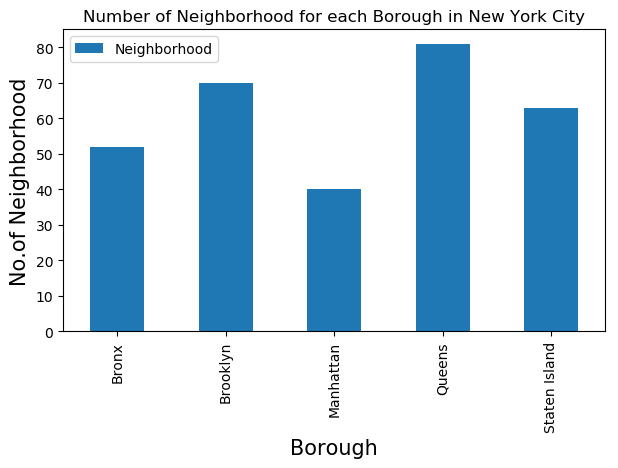

In [120]:
#Lets create a BAR PLOT to show different Neighborhoods in New York.
plt.figure(figsize=(7,4), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

##### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

In [121]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
#    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                                }, ignore_index=True)
    count+=1

In [122]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [50]:
indian_rest_ny.shape

(144, 4)

#### From the above result, we see that there are 144 Indian Resturants across New York City

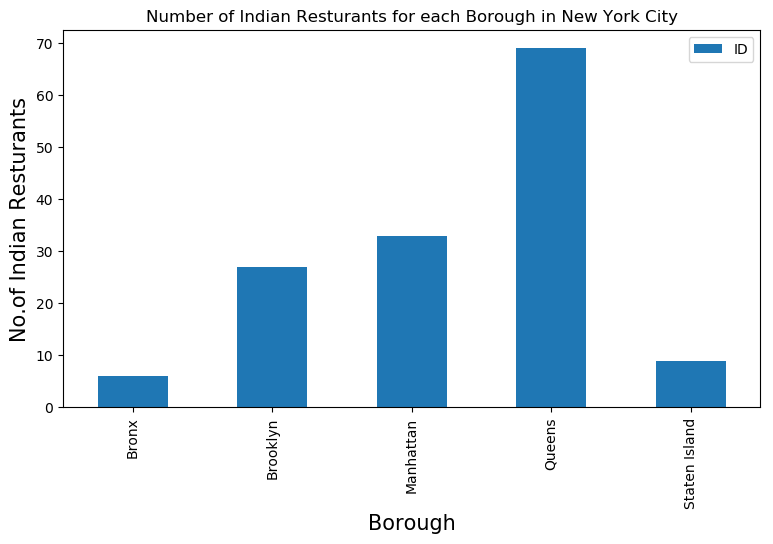

In [51]:
# lets create a BAR PLOT to show Number of Indian Resturants for each Borough in New York City.
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

#### From the above Bar Plot, we can see that Queens has highest number of Indian resturants.

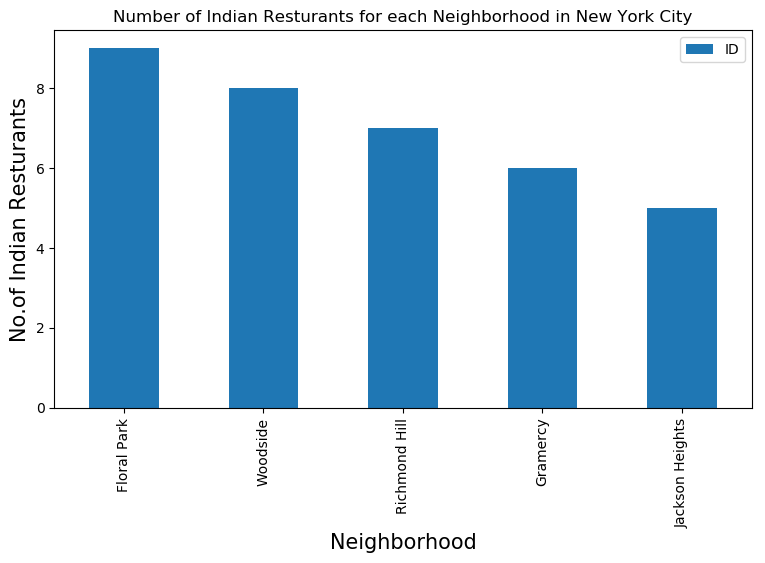

In [53]:
## lets create a BAR PLOT to show Number of Indian Resturants for each Neighbourhood in New York City.
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [54]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
142,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
143,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
144,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
145,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
146,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
147,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
148,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
149,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
150,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


#### From the graph, its clear that Floral Park in Queens has the highest number of Indian Resturants with a total count of 11

In [95]:
#Now we will get the ranking of each resturant for further analysis.

# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.6,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.8,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.1,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.9,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,5.8,2


In [97]:
indian_rest_stats_ny.shape

(144, 7)

In [101]:
# The Data type of 'Likes' and 'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
Borough         103 non-null object
Neighborhood    103 non-null object
ID              103 non-null object
Name            103 non-null object
Likes           144 non-null float64
Rating          144 non-null float64
Tips            144 non-null float64
dtypes: float64(3), object(4)
memory usage: 8.0+ KB


### Now we will find the Indian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [102]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood            Roosevelt Island
ID              4fe4fb50c2eee335e4fea69d
Name                    Moti Mahal Delux
Likes                                837
Rating                               8.8
Tips                                 260
Name: 37, dtype: object

In [103]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood             Upper West Side
ID              4b0dec08f964a520ae5223e3
Name                       Alachi Masala
Likes                                589
Rating                               9.1
Tips                                 146
Name: 40, dtype: object

In [104]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood            Roosevelt Island
ID              4fe4fb50c2eee335e4fea69d
Name                    Moti Mahal Delux
Likes                                837
Rating                               8.8
Tips                                 260
Name: 37, dtype: object

### Top neighborhoods with top average rating of Indian resturants

In [110]:
# lets visualize neighborhood with maximum average rating of resturants.
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
36,Roosevelt Island,8.80
44,Upper West Side,8.80
14,Fort Greene,8.70
35,Ridgewood,8.60
3,Boerum Hill,8.50
32,Prospect Park South,8.50
10,East Harlem,8.40
13,Floral Park,8.35
21,Jamaica Center,8.30
40,Steinway,8.20


### Average rating of Indian Resturants for each Borough

In [111]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Brooklyn,7.422727
2,Manhattan,6.622222
0,Bronx,6.440000
3,Queens,6.214286


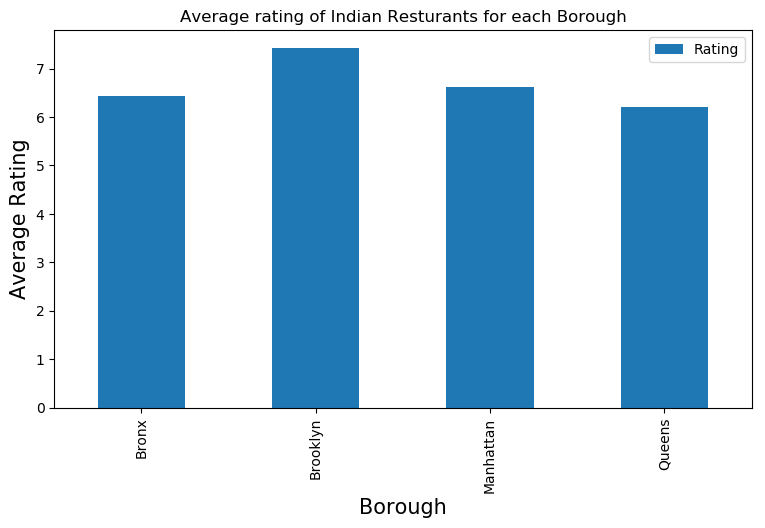

In [112]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [114]:
#Lets consider all the neighborhoods with average rating greater or equal 8.5 to visualize on map
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]
ny_neighborhood_stats

,Neighborhood,Average Rating
3,Boerum Hill,8.5
14,Fort Greene,8.7
32,Prospect Park South,8.5
35,Ridgewood,8.6
36,Roosevelt Island,8.8
44,Upper West Side,8.8


In [115]:
#We will join this dataset to original new york data to get lonitude and latitude
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.5
1,Brooklyn,Fort Greene,40.688527,-73.972906,8.7
2,Brooklyn,Prospect Park South,40.647009,-73.962613,8.5
3,Queens,Ridgewood,40.708323,-73.901435,8.6
4,Manhattan,Roosevelt Island,40.762160,-73.949168,8.8
5,Manhattan,Upper West Side,40.787658,-73.977059,8.8


In [116]:
#Plotting the data on map
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [117]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)